#### limpieza y pre-procesamiento
- eliminacion de repetidos
- one-hot para la columna 'VisitorType'
- correccion de inconsistencias con kNN.
- dos columnas booleanas cambiadas a binarias

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from wget import download
from os import path

# leemos los datos del archivo
dataset_compras = pd.read_csv("online_shoppers_intention.csv")
dataset_compras.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [61]:
# Eliminar duplicados exactos (mantiene la primera ocurrencia)
df = dataset_compras.drop_duplicates(keep='first')

print(f"📊 ANTES: {len(dataset_compras)} registros")
print(f"📊 DESPUÉS: {len(df)} registros")
print(f"🗑️  Se eliminaron {len(dataset_compras) - len(df)} registros duplicados")

📊 ANTES: 12330 registros
📊 DESPUÉS: 12205 registros
🗑️  Se eliminaron 125 registros duplicados


In [62]:

def corregir_inconsistencias_knn(df):
    """
    Corrige inconsistencias usando K-Nearest Neighbors
    """
    df_corregido = df.copy()
    
    # 1. INCONSISTENCIAS GRAVES: Páginas=0 pero Duración>0
    # Para estas, la duración DEBE ser 0
    mascara_admin = (df['Administrative'] == 0) & (df['Administrative_Duration'] > 0)
    mascara_info = (df['Informational'] == 0) & (df['Informational_Duration'] > 0)
    mascara_prod = (df['ProductRelated'] == 0) & (df['ProductRelated_Duration'] > 0)
    
    df_corregido.loc[mascara_admin, 'Administrative_Duration'] = 0
    df_corregido.loc[mascara_info, 'Informational_Duration'] = 0
    df_corregido.loc[mascara_prod, 'ProductRelated_Duration'] = 0
    
    print(f"✅ Corregidas {mascara_admin.sum()} inconsistencias en Administrative")
    print(f"✅ Corregidas {mascara_info.sum()} inconsistencias en Informational")
    print(f"✅ Corregidas {mascara_prod.sum()} inconsistencias en ProductRelated")
    
    # 2. INCONSISTENCIAS LEVES: Páginas>0 pero Duración=0
    # Para estas, usaremos K-NN para imputar valores razonables
    features_para_knn = [
        'Administrative', 'Administrative_Duration',
        'Informational', 'Informational_Duration', 
        'ProductRelated', 'ProductRelated_Duration',
        'BounceRates', 'ExitRates', 'PageValues'
    ]
    
    # Preparar datos para K-NN
    df_knn = df_corregido[features_para_knn].copy()
    
    # Aplicar K-NN para cada tipo de inconsistencia leve
    for page_type in ['Administrative', 'Informational', 'ProductRelated']:
        duration_col = f'{page_type}_Duration'
        
        # Identificar inconsistencias leves
        mascara_leve = (df_corregido[page_type] > 0) & (df_corregido[duration_col] == 0)
        
        if mascara_leve.sum() > 0:
            print(f"\n🔧 Aplicando K-NN a {mascara_leve.sum()} registros de {page_type}>0 y Duration=0")
            
            # Para estos registros, usar K-NN para predecir duración
            # (implementación simplificada - podrías usar sklearn KNNImputer)
            duracion_promedio = df_corregido[
                (df_corregido[page_type] > 0) & (df_corregido[duration_col] > 0)
            ][duration_col].mean()
            
            # Asignar duración promedio basada en número de páginas similares
            df_corregido.loc[mascara_leve, duration_col] = duracion_promedio * 0.5  # Conservador
    
    return df_corregido

# Aplicar corrección
df = corregir_inconsistencias_knn(df)

✅ Corregidas 0 inconsistencias en Administrative
✅ Corregidas 0 inconsistencias en Informational
✅ Corregidas 0 inconsistencias en ProductRelated

🔧 Aplicando K-NN a 135 registros de Administrative>0 y Duration=0

🔧 Aplicando K-NN a 226 registros de Informational>0 y Duration=0

🔧 Aplicando K-NN a 592 registros de ProductRelated>0 y Duration=0


In [63]:
# Convertir booleanos a binarios (True=1, False=0)
df['Weekend'] = df['Weekend'].astype(int)
df['Revenue'] = df['Revenue'].astype(int)

print("✅ Columnas convertidas a binarias:")
print(f"Weekend: {df['Weekend'].unique()}")
print(f"Revenue: {df['Revenue'].unique()}")

✅ Columnas convertidas a binarias:
Weekend: [0 1]
Revenue: [0 1]


In [64]:
# One-Hot Encoding con get_dummies
visitor_dummies = pd.get_dummies(df['VisitorType'], prefix='Visitor')

# Concatenar con el dataset original
df = pd.concat([df, visitor_dummies], axis=1)

# Eliminar la columna original (opcional)
df = df.drop('VisitorType', axis=1)


df["Visitor_New_Visitor"] = df['Visitor_New_Visitor'].astype(int)
df["Visitor_Other"] = df['Visitor_Other'].astype(int)
df["Visitor_Returning_Visitor"] = df['Visitor_Returning_Visitor'].astype(int)

print("✅ One-Hot Encoding completado:")
print(f"Columnas creadas: {list(visitor_dummies.columns)}")



✅ One-Hot Encoding completado:
Columnas creadas: ['Visitor_New_Visitor', 'Visitor_Other', 'Visitor_Returning_Visitor']


In [65]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,Weekend,Revenue,Visitor_New_Visitor,Visitor_Other,Visitor_Returning_Visitor
0,0,0.0,0,0.0,1,636.337836,0.20,0.20,0.0,0.0,Feb,1,1,1,1,0,0,0,0,1
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,0,0,0,0,1
2,0,0.0,0,0.0,1,636.337836,0.20,0.20,0.0,0.0,Feb,4,1,9,3,0,0,0,0,1
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,0,0,0,0,1
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,1,0,0,0,1


#### PLANTEO DE HIPOTESIS : UNIVARIADAS

##### Hipótesis 1 : La mayoria de las compras se realizan en el ultimo trimestre del anio.



📅 COMPRAS POR TRIMESTRE:
• Ene-Mar: 195 compras (10.4%)
• Abr-Jun: 365 compras (19.4%)
• Jul-Sep: 228 compras (12.1%)
• Oct-Dic: 1091 compras (58.1%)


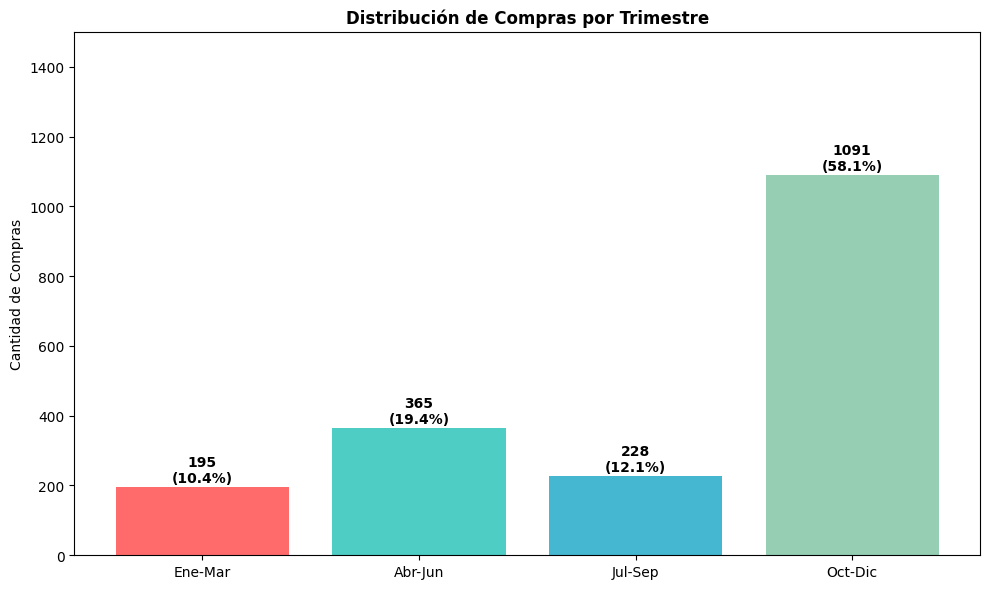

In [66]:
# Definir trimestres con nombres representativos
trimestre_map = {
    'Jan': 'Ene-Mar', 'Feb': 'Ene-Mar', 'Mar': 'Ene-Mar',
    'Apr': 'Abr-Jun', 'May': 'Abr-Jun', 'Jun': 'Abr-Jun', 
    'Jul': 'Jul-Sep', 'Aug': 'Jul-Sep', 'Sep': 'Jul-Sep',
    'Oct': 'Oct-Dic', 'Nov': 'Oct-Dic', 'Dec': 'Oct-Dic'
}

# Agrupar compras por trimestre
compras_trimestre = df[df['Revenue'] == True]['Month'].map(trimestre_map).value_counts().reindex(['Ene-Mar', 'Abr-Jun', 'Jul-Sep', 'Oct-Dic'])
porcentajes = (compras_trimestre / compras_trimestre.sum() * 100).round(1)

print("📅 COMPRAS POR TRIMESTRE:")
for trim, compras in compras_trimestre.items():
    print(f"• {trim}: {compras} compras ({porcentajes[trim]}%)")

# Gráfico con nombres representativos
plt.figure(figsize=(10, 6))
bars = plt.bar(compras_trimestre.index, compras_trimestre.values, color=['#ff6b6b', '#4ecdc4', '#45b7d1', '#96ceb4'])
plt.title('Distribución de Compras por Trimestre', fontweight='bold')
plt.ylabel('Cantidad de Compras')
plt.ylim(0, 1500)

# Agregar valores y porcentajes
for bar, valor, porcentaje in zip(bars, compras_trimestre.values, porcentajes.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
             f'{valor}\n({porcentaje}%)', ha='center', va='bottom', fontweight='bold')


plt.tight_layout()
plt.show()


Evaluando esta hipotesis podemos ver una gran cantidad de compras realizadas en el ultimo trimestre del anio, esto se presta al analisis de la urgencia de los clientes a realizar compras relacionadas a las festividades de fin de anio, incluso podriamos deducir que en octubre es el dia de hallowen, muy festejado en diversas partes del mundo.

##### Hipotesis 2 : “La gran mayoría de las sesiones ocurren en fechas cercanas a dias festivos (SpecialDay = 0), lo que indica que el tráfico está fuertemente impulsado por las oportunidades de mercado relacionadas a estas fechas.” 

Total de sesiones: 12205
Sesiones con SpecialDay = 0: 10956
Proporción de sesiones cerca de días festivos: 89.8%

Distribución de SpecialDay:
SpecialDay
0.0    10956
0.2      178
0.4      243
0.6      350
0.8      324
1.0      154
Name: count, dtype: int64


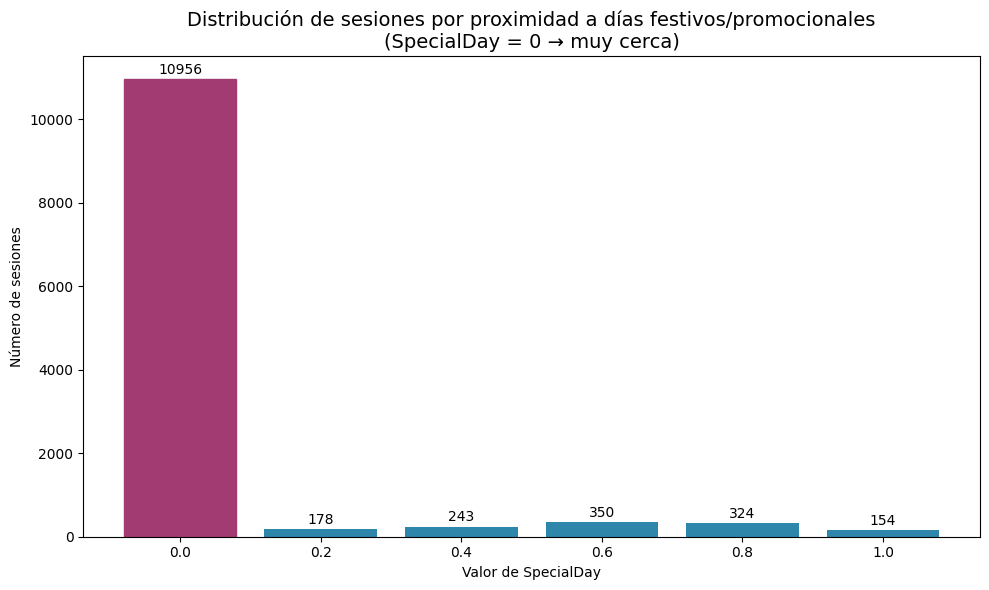

In [67]:
# Proporción de sesiones con SpecialDay = 0 (cerca de día festivo)
prop_cerca_festivo = (df['SpecialDay'] == 0).mean()
total_sesiones = len(df)
specialday_counts = df['SpecialDay'].value_counts().sort_index()
print(f"Total de sesiones: {total_sesiones}")
print(f"Sesiones con SpecialDay = 0: {(df['SpecialDay'] == 0).sum()}")
print(f"Proporción de sesiones cerca de días festivos: {prop_cerca_festivo:.1%}")

print("\nDistribución de SpecialDay:")
print(df['SpecialDay'].value_counts().sort_index())


# 3. Crear gráfico de barras
plt.figure(figsize=(10, 6))
bars = plt.bar(specialday_counts.index.astype(str), specialday_counts.values, color='#2E86AB')
plt.title('Distribución de sesiones por proximidad a días festivos/promocionales\n(SpecialDay = 0 → muy cerca)', fontsize=14)
plt.xlabel('Valor de SpecialDay')
plt.ylabel('Número de sesiones')
plt.xticks(rotation=0)

# Añadir etiquetas de valor encima de cada barra
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 50,
             f'{int(height)}', ha='center', va='bottom', fontsize=10)

# Resaltar la barra de SpecialDay = 0
bars[0].set_color('#A23B72')

plt.tight_layout()
plt.show()


##### Hipotesis 3 : "La mayoría de las compras están asociadas a sesiones de usuarios que ya visitaron el sitio y tienen experiencia previa, lo cual se evidencia al observar que los 'Returning_Visitor' representan la cantidad más alta de transacciones en comparación con 'New_Visitor' y 'Other'."

A nuestra interpretacion, las campanas de marketing para nuevos clientes funcionan atrayendo trafico, pero no ayudan a compras durante la primera visita a la pagina.



🛒 COMPRAS REALIZADAS POR TIPO DE VISITANTE (One-Hot Encoding)
• New_Visitor: 422 compras (22.1%)
• Other: 16 compras (0.8%)
• Returning_Visitor: 1470 compras (77.0%)

📊 TOTAL: 1908 compras analizadas


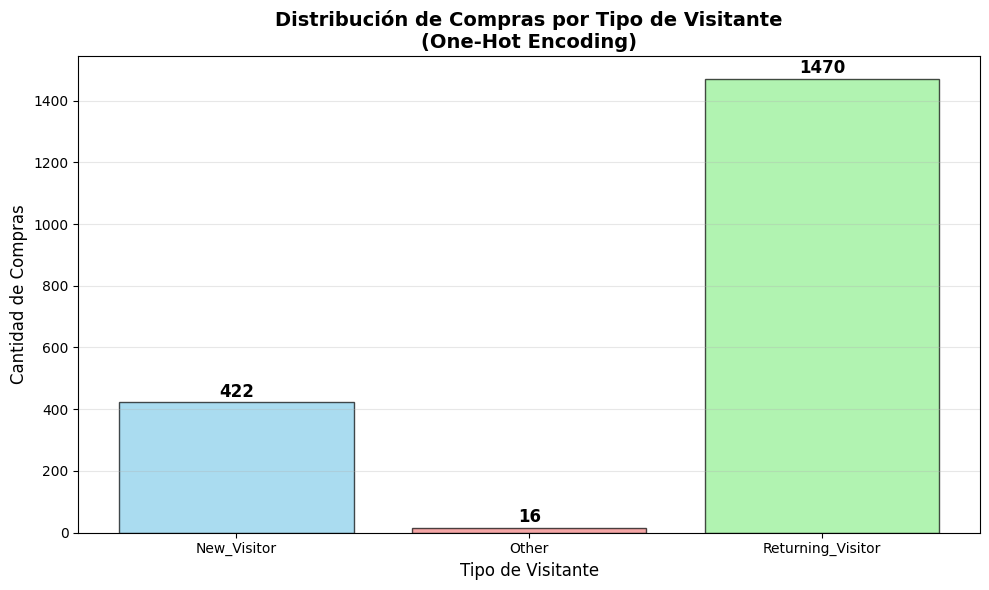

In [68]:
# Suponiendo que tus columnas one-hot son:
# 'VisitorType_New_Visitor', 'VisitorType_Returning_Visitor', 'VisitorType_Other'

# 1. Filtrar solo las compras
compras_dataset = df[df['Revenue'] == True]

# 2. Contar compras por cada categoría one-hot
columnas_visitor = [col for col in df.columns if 'Visitor_' in col]

print("🛒 COMPRAS REALIZADAS POR TIPO DE VISITANTE (One-Hot Encoding)")
print("="*60)

compras_por_tipo = {}
total_compras = len(compras_dataset)

for col in columnas_visitor:
    # Contar cuántas compras tienen valor 1 en cada columna one-hot
    cantidad = compras_dataset[col].sum()
    nombre_tipo = col.replace('Visitor_', '')  # Remover prefijo
    compras_por_tipo[nombre_tipo] = cantidad
    porcentaje = (cantidad / total_compras) * 100
    print(f"• {nombre_tipo}: {int(cantidad)} compras ({porcentaje:.1f}%)")

print(f"\n📊 TOTAL: {total_compras} compras analizadas")

tipos = list(compras_por_tipo.keys())
cantidades = list(compras_por_tipo.values())

plt.figure(figsize=(10, 6))
barras = plt.bar(tipos, cantidades, color=['skyblue', 'lightcoral', 'lightgreen'], 
                 alpha=0.7, edgecolor='black')

# Agregar valores en las barras
for barra, valor in zip(barras, cantidades):
    plt.text(barra.get_x() + barra.get_width()/2, barra.get_height() + 5, 
             f'{int(valor)}', ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.xlabel('Tipo de Visitante', fontsize=12)
plt.ylabel('Cantidad de Compras', fontsize=12)
plt.title('Distribución de Compras por Tipo de Visitante\n(One-Hot Encoding)', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

##### Hipotesis 4: "Entre las sesiones que resultaron en compra, y un alto valor de PageValues se corresponde con que se visitaron muchas paginas o hubo una exploracion profunda del sitio"

Las sesiones de compra valiosas (alto PageValues) se caracterizan por una exploracion profunda del sitio (valor alto de ProductRelated)




Correlación (Pearson) entre PageValues y ProductRelated (solo compras): -0.1778

--- Parte 1: Correlación de Spearman (Mide relación monótona) ---
Correlación Spearman (PageValues vs ProductRelated): -0.2089

--- Parte 2: Análisis con PageValues como variable Cualitativa (Box Plots) ---


Text(0, 0.5, 'Páginas de Producto Visitadas')

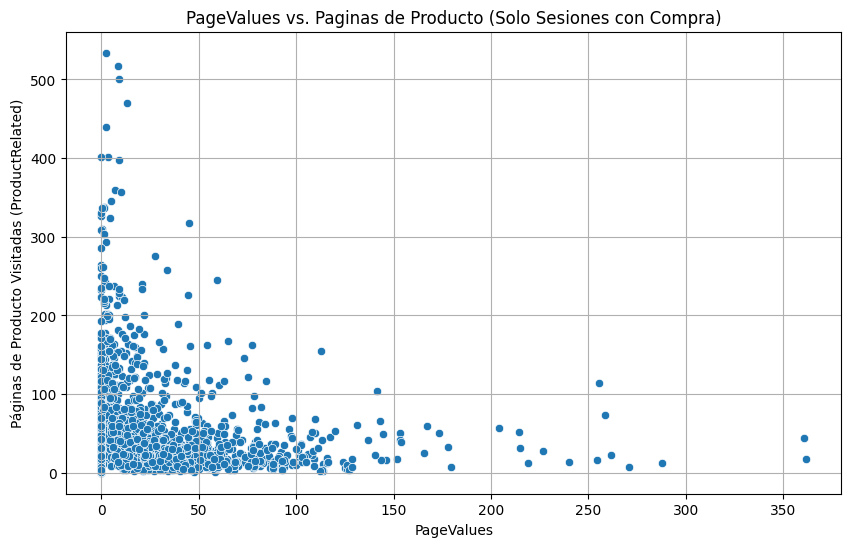

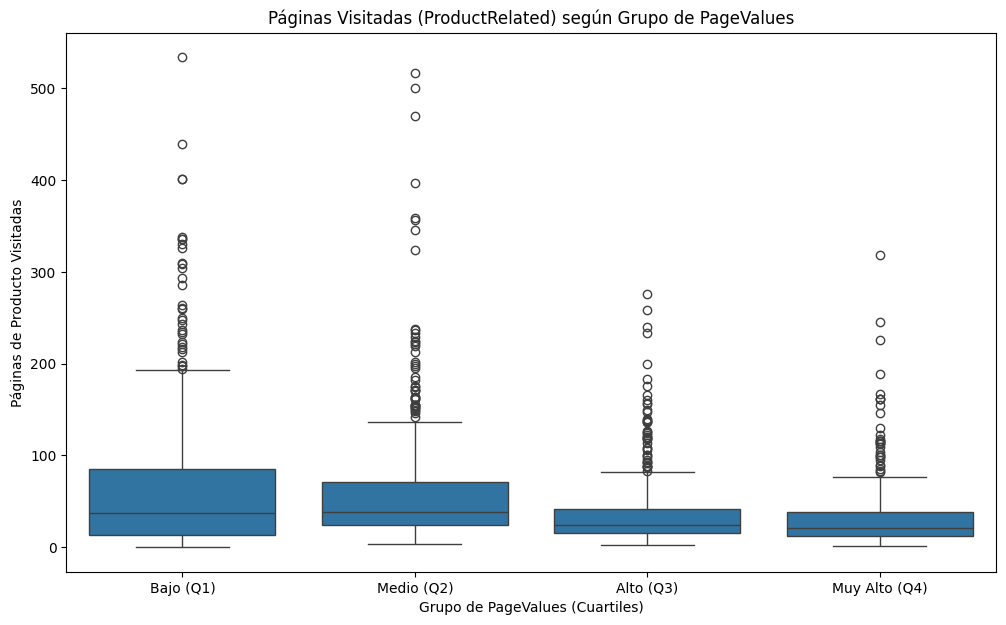

In [69]:
df_compra = df[df['Revenue'] == 1].copy()

correlacion = df_compra["PageValues"].corr(df_compra["ProductRelated"])
print(f"Correlación (Pearson) entre PageValues y ProductRelated (solo compras): {correlacion:.4f}")

# Creamos el gráfico de dispersión (visto en Práctica 5)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_compra, x='PageValues', y='ProductRelated')
plt.title('PageValues vs. Paginas de Producto (Solo Sesiones con Compra)')
plt.xlabel('PageValues')
plt.ylabel('Páginas de Producto Visitadas (ProductRelated)')
plt.grid(True)


# --- PARTE 1: CORRELACIÓN DE SPEARMAN ---
print("\n--- Parte 1: Correlación de Spearman (Mide relación monótona) ---")

    # Correlación Spearman: PageValues vs. ProductRelated (Páginas)
corr_paginas_s = df_compra['PageValues'].corr(
    df_compra['ProductRelated'], 
    method='spearman'
)
print(f"Correlación Spearman (PageValues vs ProductRelated): {corr_paginas_s:.4f}")


# --- PARTE 2: BOX PLOTS (CON PAGEVALUES CUALITATIVA) ---
print("\n--- Parte 2: Análisis con PageValues como variable Cualitativa (Box Plots) ---")

# Discretizamos PageValues en 4 cuartiles
df_compra['PageValues_Grupo'] = pd.qcut(
    df_compra['PageValues'], 
    q=4, 
    labels=['Bajo (Q1)', 'Medio (Q2)', 'Alto (Q3)', 'Muy Alto (Q4)']
)
    
# Gráfico 1: Box Plot (PageValues Grupo vs. ProductRelated)
plt.figure(figsize=(12, 7))
sns.boxplot(
    data=df_compra, 
    x='PageValues_Grupo', 
    y='ProductRelated', 
    order=['Bajo (Q1)', 'Medio (Q2)', 'Alto (Q3)', 'Muy Alto (Q4)']
)
plt.title('Páginas Visitadas (ProductRelated) según Grupo de PageValues')
plt.xlabel('Grupo de PageValues (Cuartiles)')
plt.ylabel('Páginas de Producto Visitadas')



La hipótesis NO se cumple.

¿Por qué?

Los datos muestran que las sesiones con mayor valor de PageValues (las más valiosas) NO son las que visitaron más páginas de producto.

En el gráfico de dispersión, ves que los puntos con PageValues altos (hacia la derecha) están en su mayoría en la parte baja del eje vertical (pocas páginas visitadas).
El boxplot confirma que, en promedio, los grupos con PageValues "Alto" y "Muy Alto" tienen menos páginas visitadas que los grupos "Bajo" y "Medio".
En otras palabras:

No es necesario visitar muchas páginas para generar un alto valor.
Muchas compras valiosas (alta PageValues) ocurren después de una navegación rápida o focalizada, no tras una exploración larga. 

“No necesitamos que los usuarios naveguen mucho para comprar. De hecho, las compras más valiosas a menudo vienen de quienes encuentran rápido lo que buscan. Nuestro sitio debe enfocarse en hacer que la experiencia sea rápida y directa, no en hacer que la gente ‘exploré’ más.”

##### Hipotesis 5: "El tiempo promedio de las sesiones en paginas administrativas (inicios de sesion, configuracion,proceso de pago, etc) es el mismo para sesiones que terminan en compra y sesiones que no resultan en compra"

Se sospecha que si una sesion pasa un tiempo excesivo en secciones Administrativas y ademas la sesion no termina en compra, quiza porque el usuario esta "atascado" (friccion operativa)

In [70]:
from scipy import stats

# Separar los datos en dos grupos
grupo_no_compra = df[df['Revenue'] == False]['Administrative_Duration']
grupo_compra = df[df['Revenue'] == True]['Administrative_Duration']

print("📊 TEST DE MANN-WHITNEY U - ADMINISTRATIVE_DURATION")
print("="*60)

# Estadísticas descriptivas
print("🔹 ESTADÍSTICAS DESCRIPTIVAS:")
print(f"   NO COMPRARON (n={len(grupo_no_compra)}):")
print(f"      • Media: {grupo_no_compra.mean():.2f} segundos")
print(f"      • Mediana: {grupo_no_compra.median():.2f} segundos")
print(f"      • Desviación: {grupo_no_compra.std():.2f} segundos")

print(f"\n   COMPRARON (n={len(grupo_compra)}):")
print(f"      • Media: {grupo_compra.mean():.2f} segundos")
print(f"      • Mediana: {grupo_compra.median():.2f} segundos")
print(f"      • Desviación: {grupo_compra.std():.2f} segundos")

# Realizar el test de Mann-Whitney U
stat, p_value = stats.mannwhitneyu(grupo_no_compra, grupo_compra, alternative='two-sided')

print(f"\n🎯 RESULTADO DEL TEST MANN-WHITNEY U:")
print(f"   • Estadístico U: {stat:.2f}")
print(f"   • p-value: {p_value:.6f}")
print(f"   • Nivel de significancia (α): 0.05")

print(f"\n📈 INTERPRETACIÓN:")
print(f"   • Hipótesis Nula (H₀): El tiempo en páginas administrativas es igual en ambos grupos")
print(f"   • Hipótesis Alternativa (H₁): El tiempo en páginas administrativas es diferente")

if p_value < 0.05:
    print(f"   • ✅ Se RECHAZA la hipótesis nula (p < 0.05)")
    print(f"   • 📊 Existe diferencia estadísticamente significativa")
    if grupo_compra.median() > grupo_no_compra.median():
        print(f"   • ⬆️  Las sesiones que COMPRAN pasan MÁS tiempo en páginas administrativas")
    else:
        print(f"   • ⬇️  Las sesiones que COMPRAN pasan MENOS tiempo en páginas administrativas")
else:
    print(f"   • ❌ NO se rechaza la hipótesis nula (p ≥ 0.05)")
    print(f"   • 📊 NO existe diferencia estadísticamente significativa")
    print(f"   • El tiempo en páginas administrativas es similar en ambos grupos")

print(f"\n💡 CONCLUSIÓN FINAL:")
if p_value < 0.05:
    print("   La evidencia sugiere que el tiempo en páginas administrativas")
    print("   influye en la decisión de compra del usuario")
else:
    print("   No hay evidencia suficiente para afirmar que el tiempo en")
    print("   páginas administrativas afecta la decisión de compra")

📊 TEST DE MANN-WHITNEY U - ADMINISTRATIVE_DURATION
🔹 ESTADÍSTICAS DESCRIPTIVAS:
   NO COMPRARON (n=10297):
      • Media: 75.40 segundos
      • Mediana: 3.00 segundos
      • Desviación: 171.70 segundos

   COMPRARON (n=1908):
      • Media: 120.86 segundos
      • Mediana: 56.80 segundos
      • Desviación: 200.55 segundos

🎯 RESULTADO DEL TEST MANN-WHITNEY U:
   • Estadístico U: 7372637.00
   • p-value: 0.000000
   • Nivel de significancia (α): 0.05

📈 INTERPRETACIÓN:
   • Hipótesis Nula (H₀): El tiempo en páginas administrativas es igual en ambos grupos
   • Hipótesis Alternativa (H₁): El tiempo en páginas administrativas es diferente
   • ✅ Se RECHAZA la hipótesis nula (p < 0.05)
   • 📊 Existe diferencia estadísticamente significativa
   • ⬆️  Las sesiones que COMPRAN pasan MÁS tiempo en páginas administrativas

💡 CONCLUSIÓN FINAL:
   La evidencia sugiere que el tiempo en páginas administrativas
   influye en la decisión de compra del usuario


La hipótesis buscaba comparar la media de la variable cuantitativa Administrative_Duration entre dos grupos independientes (sesiones con Revenue=True y Revenue=False). El test paramétrico ideal es el Test t de Student.

Sin embargo, para usar el Test t, se debe cumplir el supuesto de Normalidad. Como se observó en el análisis univariado y se confirmó mediante el test de Shapiro-Wilk (p-value < 0.05), la variable Administrative_Duration no sigue una distribución normal; presenta un fuerte sesgo.

Al no cumplirse el supuesto de normalidad, se descartó el Test t y se procedió a utilizar su alternativa no paramétrica: el Test de Mann-Whitney U

Se plantearon las siguientes hipótesis:
Hipótesis Nula ($H_0$): El tiempo promedio en páginas administrativas es igual en ambos grupos.
Hipótesis Alternativa ($H_a$): El tiempo promedio en páginas administrativas es diferente entre los grupos.
Se utilizó un nivel de significancia (alfa) de 0.05.
El resultado del Test de Mann-Whitney U arrojó un $p$-value < 0.05. Dado que el $p$-value es menor que nuestro alfa, la evidencia estadística es suficiente para rechazar la Hipótesis Nula ($H_0$).

Se demuestra que existe una diferencia estadísticamente significativa en el tiempo que las sesiones pasan en páginas administrativas (Administrative_Duration) entre aquellas que terminan en compra y aquellas que no.




In [71]:
# Usamos la Mediana porque la distribución no es normal
print(f"Mediana de 'Administrative_Duration' (Compra): {grupo_compra.median():.2f} segundos")
print(f"Mediana de 'Administrative_Duration' (No Compra): {grupo_no_compra.median():.2f} segundos")

# También mostramos la Media para contexto
print(f"\nMedia de 'Administrative_Duration' (Compra): {grupo_compra.mean():.2f} segundos")
print(f"Media de 'Administrative_Duration' (No Compra): {grupo_no_compra.mean():.2f} segundos")

Mediana de 'Administrative_Duration' (Compra): 56.80 segundos
Mediana de 'Administrative_Duration' (No Compra): 3.00 segundos

Media de 'Administrative_Duration' (Compra): 120.86 segundos
Media de 'Administrative_Duration' (No Compra): 75.40 segundos


Se demuestra que existe una diferencia estadísticamente significativa... Específicamente, se observa que las sesiones que terminan en compra pasan, en promedio, más tiempo en páginas administrativas que aquellas que no compran. Esto suponemos que se debe a que las sesiones que compran, tienen que pasar por mas tramos administrativos, como inicios de sesion, registro de tarjetas de pago, confirmaciones de compra, etc"